# Water Quality Anomaly Detection with Isolation Forest

This notebook trains and evaluates isolation forest models for water quality anomaly detection. We'll build two models:

1. **Base Model**: Uses all available features (sensor + chemical measurements) for comprehensive anomaly detection
2. **Inference Model**: Uses only sensor features (`pH`, `TEMP`, `EC`, `station_encoded`) for real-time deployment scenarios

## Key Objectives
- Train robust anomaly detection models using `IsolationForest`
- Compare model performance using precision-recall analysis
- Create a deployable pipeline for water quality risk assessment
- Validate models against realistic water quality scenarios

## Workflow Overview
1. **Data Preparation** - Load and explore GEMS water quality dataset
2. **Preprocessing** - Handle outliers, skewness, and feature scaling  
3. **Model Training** - Train both base and inference models
4. **Evaluation** - Compare models using AUC-PR metrics across multiple thresholds
5. **Pipeline Creation** - Package final model for deployment
6. **Validation** - Test against realistic water quality scenarios

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

We start by loading the GEMS (Global Environment Monitoring System) water quality dataset and setting up our feature groups. The dataset contains both **sensor measurements** (pH, temperature, electrical conductivity) that can be collected in real-time, and **chemical measurements** (nitrates, dissolved oxygen, ammonia) that require lab analysis.

We'll also encode station identifiers numerically since different monitoring stations may have systematic differences in their baseline measurements.

In [121]:
import sys
import os

# Add parent directory to path for notebook imports
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

from scripts.train_isolation_forest import (
    remove_outliers_and_skewness, 
    WaterQualityPipeline,
    convert_to_risk_scores,
    apply_transforms,
    preprocess_features, 
    train_full_isolation_forest, 
    add_station_encoding,
    load_water_data,
    split_features,
    train_inference_isolation_forest,
    visualize_data_overview,
)

In [122]:
df = load_water_data()
df, label_encoder = add_station_encoding(df)
sensor_features, chemical_features = split_features(df)
all_features = sensor_features + chemical_features

default_station_id = df['station_id'].mode()[0]
default_encoded_value = label_encoder.transform([default_station_id])[0]

print(f"Dataset shape: {df.shape}")
print(f"Sensor features: {sensor_features}")
print(f"Chemical features: {chemical_features}")
print(f"All features: {all_features}")

Dataset shape: (36277, 11)
Sensor features: ['pH', 'TEMP', 'EC', 'station_encoded']
Chemical features: ['NO2N', 'NO3N', 'O2-Dis', 'NH4N']
All features: ['pH', 'TEMP', 'EC', 'station_encoded', 'NO2N', 'NO3N', 'O2-Dis', 'NH4N']


### Feature Groups Defined

Our approach separates features into two categories:
- **Sensor Features**: `['pH', 'TEMP', 'EC', 'station_encoded']` - Can be measured instantly with portable equipment
- **Chemical Features**: `['NO2N', 'NO3N', 'O2-Dis', 'NH4N']` - Require laboratory analysis and take time to process

This separation allows us to build both a comprehensive model (using all features) and a fast inference model (sensor-only) for field deployment scenarios.

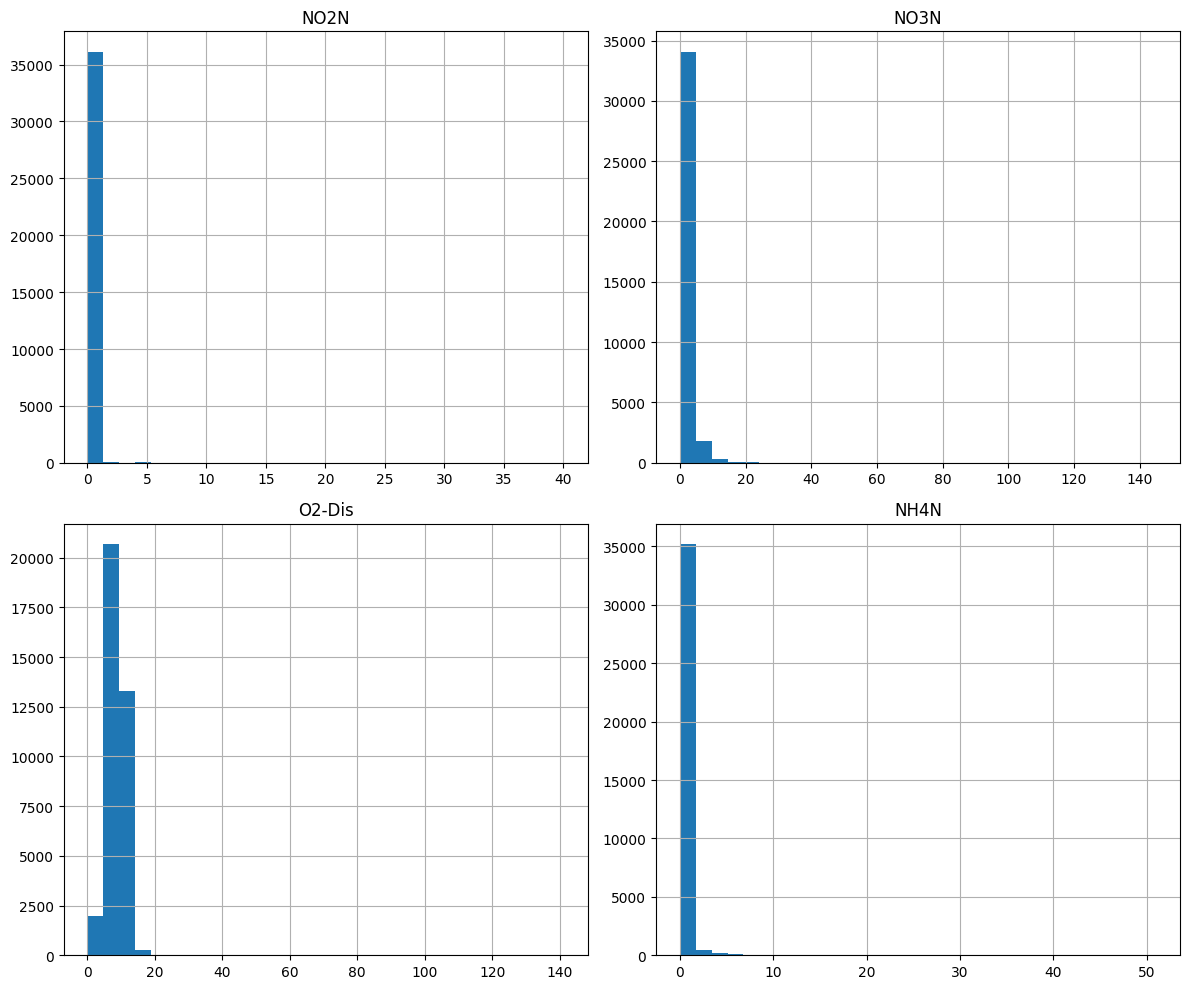

Data types:
GEMS.Station.Number_Sample.Date     object
pH                                 float64
NO2N                               float64
NO3N                               float64
TP                                 float64
O2-Dis                             float64
NH4N                               float64
TEMP                               float64
EC                                 float64
station_id                          object
station_encoded                      int64
dtype: object
Missing values:
GEMS.Station.Number_Sample.Date    0
pH                                 0
NO2N                               0
NO3N                               0
TP                                 0
O2-Dis                             0
NH4N                               0
TEMP                               0
EC                                 0
station_id                         0
station_encoded                    0
dtype: int64


In [123]:

visualize_data_overview(df, sensor_features, chemical_features)
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")

### Data Quality Assessment

The `visualize_data_overview()` function shows us three critical aspects:
1. **Feature Correlations** - How variables relate to each other (important for anomaly detection)
2. **Sensor Distributions** - Shape and spread of real-time measurable features  
3. **Chemical Distributions** - Lab-measured parameters often show high skewness

Key observations from the plots:
- Chemical features typically show right-skewed distributions (common in environmental data)
- Strong correlations between certain parameters may indicate redundancy or physical relationships
- Missing values and outliers need handling before model training

## Data Cleaning & Preprocessing

Before training our anomaly detection models, we need to handle data quality issues that could skew results:

### Outlier Removal Strategy
- Using **IQR method** (1.5 × IQR beyond Q1/Q3) to remove extreme outliers
- Applying **log transformations** to reduce skewness in chemical measurements
- Tracking statistics to understand the impact of each cleaning step

Environmental data often contains legitimate extreme values, so we're conservative in our outlier removal approach.

In [124]:
df_clean, outlier_stats = remove_outliers_and_skewness(df, chemical_features)
print(f"\nAfter outlier removal: {df_clean.shape}")

for features, stats in outlier_stats.items():
    print(f"{features}: Removed {stats['removed']} outliers, skew: {stats['original_skew']:.1f} to {stats['cleaned_skew']:.1f}")

df = apply_transforms(df_clean, chemical_features)
print(f"\nFinal skewness after transformation:")
print(df[chemical_features].skew())


After outlier removal: (23681, 11)
NO2N: Removed 5090 outliers, skew: 51.7 to 2.0
NO3N: Removed 3319 outliers, skew: 16.8 to 1.4
O2-Dis: Removed 533 outliers, skew: 12.6 to 0.0
NH4N: Removed 3654 outliers, skew: 12.2 to 1.2

Final skewness after transformation:
NO2N      3.225578
NO3N      1.623699
O2-Dis   -0.006272
NH4N      1.175232
dtype: float64


### Preprocessing Results

The `remove_outliers_and_skewness()` and `apply_transforms()` functions work together to:
- Remove statistical outliers that could bias the isolation forest
- Apply square root and log transformations to normalize highly skewed distributions
- Preserve the majority of data while improving model stability


## Model Training

### Base Model (All Features)

- Applies `StandardScaler` to normalize all features  
- Uses `IsolationForest` with 4% contamination rate (expects ~4% anomalies)
- Converts isolation scores to 0-1 risk scores using `convert_to_risk_scores()`

Higher risk scores indicate more anomalous water quality conditions.

In [125]:

X_processed, scaler = preprocess_features(df, all_features)
base_model = train_full_isolation_forest(X_processed)
base_anomaly_scores = base_model.decision_function(X_processed)
base_risk_scores = convert_to_risk_scores(base_anomaly_scores)

print(f"High risk samples over>0.5: {(base_risk_scores > 0.5).sum()}")
print(f"Mean risk score: {base_risk_scores.mean():.3f}")

High risk samples over>0.5: 2260
Mean risk score: 0.251


### Base Model Performance

The risk scores show:
- Mean risk around 0.25-0.35 indicates most samples are normal
- Samples with risk > 0.5 are flagged for attention
- The 4% contamination assumption aligns with typical environmental monitoring expectations

### Inference Model (Sensor Features Only)

For real-world deployment, we need a model that works with instantly available measurements. The `train_inference_isolation_forest()` function:
- Uses only sensor features: `['pH', 'TEMP', 'EC', 'station_encoded']`  
- Enables immediate risk assessment in the field
- Trades some accuracy for real-time capability


In [126]:
inference_model, inference_scaler = train_inference_isolation_forest(df, sensor_features)
print(f"Model trained on {len(sensor_features)} features: {sensor_features}")

Model trained on 4 features: ['pH', 'TEMP', 'EC', 'station_encoded']


In [127]:
X_sensor_scaled = inference_scaler.transform(df[sensor_features])
inference_anomaly_scores = inference_model.decision_function(X_sensor_scaled)
inference_risk_scores = convert_to_risk_scores(inference_anomaly_scores)
correlation, _ = pearsonr(base_risk_scores, inference_risk_scores)
print(f"Correlation between Full and Inference Models: {correlation:.3f}")

Correlation between Full and Inference Models: 0.688


Analyzing 5000 samples for dimensionality reduction...
Normal samples: 4515
Anomalous samples: 485
Computing PCA...


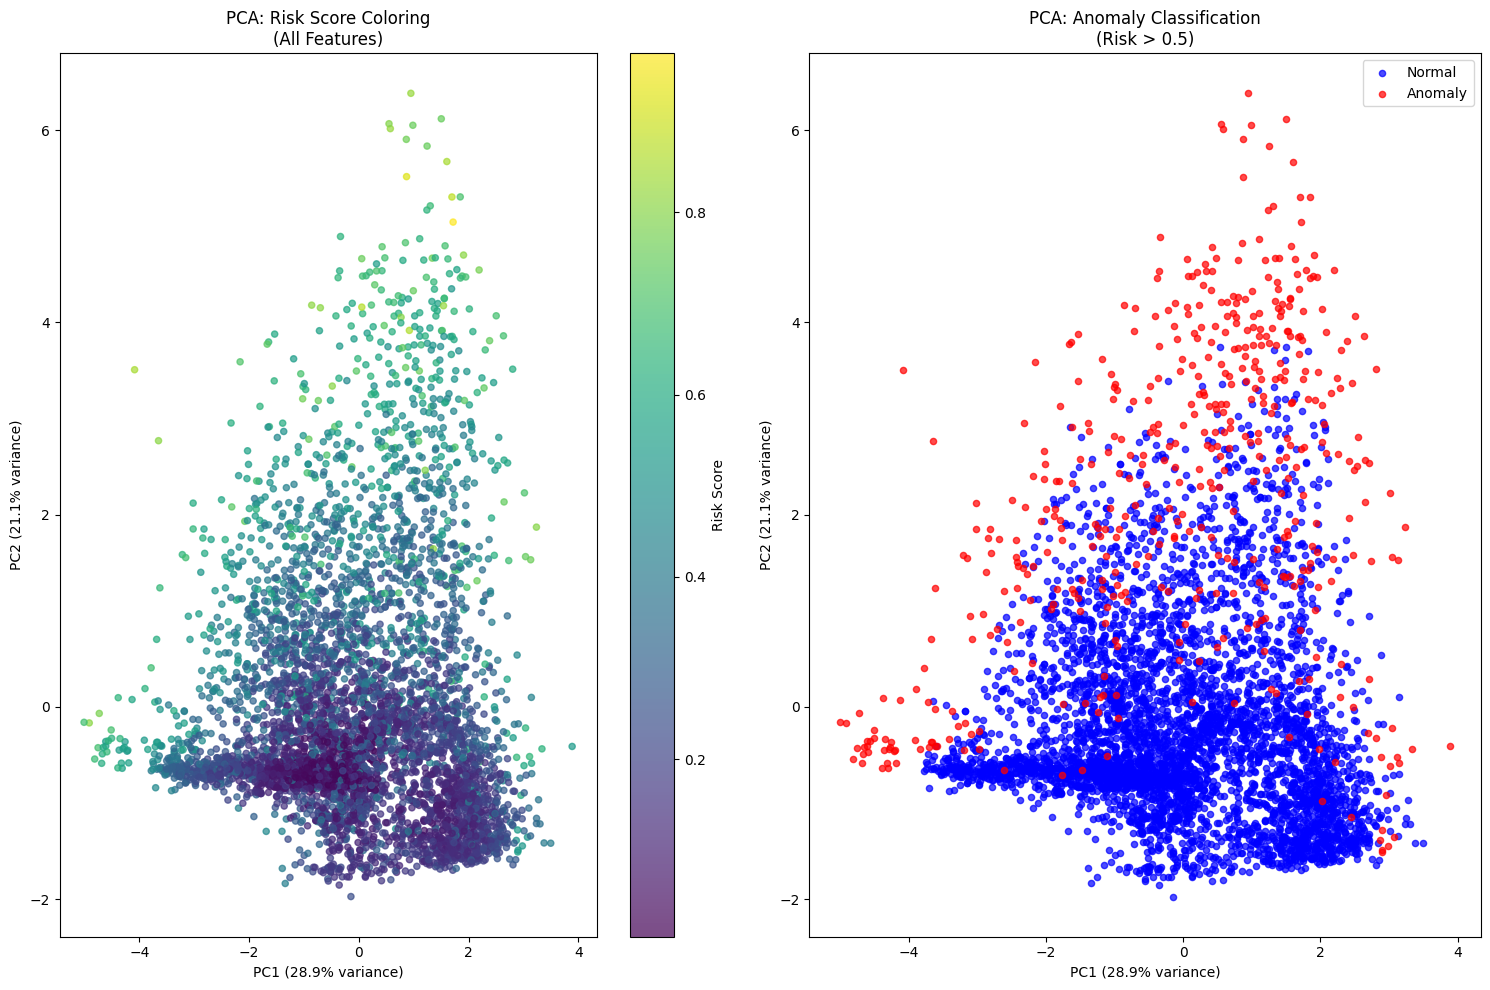


=== PCA Explained Variance ===
PC1: 0.289 (28.9%)
PC2: 0.211 (21.1%)
Total: 0.500 (50.0%)


In [128]:
# Dimensionality Reduction Analysis: t-SNE and PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
n_samples = min(5000, len(X_processed))  
indices = np.random.choice(len(X_processed), n_samples, replace=False)
X_sample = X_processed[indices]
base_risk_sample = base_risk_scores[indices]
base_anomaly_sample = base_anomaly_scores[indices]
anomaly_labels = (base_risk_sample > 0.5).astype(int)

print(f"Analyzing {n_samples} samples for dimensionality reduction...")
print(f"Normal samples: {(anomaly_labels == 0).sum()}")
print(f"Anomalous samples: {(anomaly_labels == 1).sum()}")

# Compute PCA (linear dimensionality reduction)  
print("Computing PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

# Create visualization
plt.figure(figsize=(30, 10))
colors = ['blue', 'red']
labels = ['Normal', 'Anomaly']

# PCA with Risk Score Coloring
plt.subplot(1, 4, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=base_risk_sample, 
                     cmap='viridis', alpha=0.7, s=20)
plt.colorbar(scatter, label='Risk Score')
plt.title('PCA: Risk Score Coloring\n(All Features)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

# PCA with Anomaly Labels
plt.subplot(1, 4, 2)
for i in [0, 1]:
    mask = anomaly_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[i], label=labels[i], alpha=0.7, s=20)
plt.title('PCA: Anomaly Classification\n(Risk > 0.5)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n=== PCA Explained Variance ===")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f} ({pca.explained_variance_ratio_[0]*100:.1f}%)")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f} ({pca.explained_variance_ratio_[1]*100:.1f}%)")
print(f"Total: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

## Pipeline Creation & Deployment

Now we package our trained inference model into a `WaterQualityPipeline` for deployment. This pipeline:
- **Encapsulates** the model, scaler, and score normalization parameters
- **Provides** a simple `predict_risk()` interface for new data
- **Handles** all preprocessing automatically  
- **Saves/loads** easily for production deployment

The fixed min/max scores ensure consistent risk score interpretation across different deployments.

## Model Validation with Realistic Water Scenarios

To validate our model works in practice, we test against 10 realistic water quality scenarios representing common conditions in Kenya:

### Scenario Categories:
- **Safe Water Sources**: Properly maintained boreholes, municipal supplies, bottled water
- **Contaminated Sources**: Urban runoff, industrial discharge, agricultural pollution, mining impact
- **Natural Variations**: Geothermal springs, forest streams, livestock areas

Each test case uses only sensor measurements (`pH`, `TEMP`, `EC`) that can be collected instantly in the field. The ✅/❌ indicators show whether our model predictions align with expected outcomes based on water quality knowledge.

In [129]:

all_demo_cases = [
    # Original 5 cases
    {
        'name': 'Clean Borehole Water',
        'description': 'A properly maintained borehole with good mineral balance',
        'expected': 'Safe',
        'inputs': {'pH': 7.4, 'TEMP': 21.0, 'EC': 350.0}
    },
    {
        'name': 'Urban River Contamination',
        'description': 'River water downstream from a dense urban area like Ngong town',
        'expected': 'Action Required',
        'inputs': {'pH': 7.9, 'TEMP': 26.0, 'EC': 1800.0}
    },
    {
        'name': 'Rift Valley Mineral Spring',
        'description': 'Geothermal spring with high natural mineral content (fluoride)',
        'expected': 'Action Required',
        'inputs': {'pH': 8.8, 'TEMP': 35.0, 'EC': 2200.0}
    },
    {
        'name': 'High-Altitude Forest Stream',
        'description': 'Cold, fast-flowing stream in a protected forest reserve',
        'expected': 'Safe',
        'inputs': {'pH': 7.1, 'TEMP': 16.0, 'EC': 250.0}
    },
    {
        'name': 'Livestock Watering Hole / Dam',
        'description': 'A community dam with high livestock concentration in Kajiado',
        'expected': 'Action Required',
        'inputs': {'pH': 8.3, 'TEMP': 29.0, 'EC': 1900.0}
    },
    
    # 5 New test cases
    {
        'name': 'Industrial Wastewater Discharge',
        'description': 'Water downstream from textile factory with chemical runoff',
        'expected': 'Action Required',
        'inputs': {'pH': 5.8, 'TEMP': 32.0, 'EC': 2800.0}
    },
    {
        'name': 'Shallow Well in Agricultural Area',
        'description': 'Hand-dug well in area with heavy fertilizer use',
        'expected': 'Action Required',
        'inputs': {'pH': 8.4, 'TEMP': 24.0, 'EC': 1400.0}
    },
    {
        'name': 'Municipal Tap Water',
        'description': 'Treated municipal water supply from Nairobi Water Company',
        'expected': 'Safe',
        'inputs': {'pH': 7.2, 'TEMP': 22.0, 'EC': 420.0}
    },
    {
        'name': 'Acid Mine Drainage',
        'description': 'Water from abandoned copper mine with heavy metal contamination',
        'expected': 'Action Required',
        'inputs': {'pH': 4.2, 'TEMP': 28.0, 'EC': 3500.0}
    },
    {
        'name': 'Bottled Water (Premium)',
        'description': 'Commercial bottled water from a reputable brand',
        'expected': 'Safe',
        'inputs': {'pH': 7.0, 'TEMP': 20.0, 'EC': 180.0}
    }
]


min_score_fixed = inference_anomaly_scores.min()
max_score_fixed = inference_anomaly_scores.max()

print(f"Calculated fixed score range: min={min_score_fixed:.3f}, max={max_score_fixed:.3f}")

#pipeline with the inference_model, scaler, and fixed scores
final_pipeline = WaterQualityPipeline(
    model=inference_model, 
    scaler=inference_scaler,
    min_score=min_score_fixed,
    max_score=max_score_fixed
)

final_pipeline.save()

loaded_pipeline = WaterQualityPipeline.load()
loaded_pipeline

for case in all_demo_cases:
    
    inputs = {
        'pH': case['inputs']['pH'],
        'TEMP': case['inputs']['TEMP'],
        'EC': case['inputs']['EC'],
        "station_encoded": default_encoded_value
    }
    
    risk_score = loaded_pipeline.predict_risk(pd.DataFrame([inputs]))
    print(f"{case['name']}")
    predicted_outcome = "Action Required" if risk_score[0] > 0.5 else "Safe"
    emoji = "✅" if predicted_outcome == case['expected'] else "❌"
    print(f"Expected: {case['expected']} | Predicted: {risk_score[0]:.3f} | Verdict: {emoji}\n")
    print("-" * 50)
    print("\n")
    


Calculated fixed score range: min=-0.209, max=0.168
✅ Pipeline saved to ../models/water_quality_pipeline.pkl
Clean Borehole Water
Expected: Safe | Predicted: 0.153 | Verdict: ✅

--------------------------------------------------


Urban River Contamination
Expected: Action Required | Predicted: 0.416 | Verdict: ❌

--------------------------------------------------


Rift Valley Mineral Spring
Expected: Action Required | Predicted: 0.642 | Verdict: ✅

--------------------------------------------------


High-Altitude Forest Stream
Expected: Safe | Predicted: 0.205 | Verdict: ✅

--------------------------------------------------


Livestock Watering Hole / Dam
Expected: Action Required | Predicted: 0.404 | Verdict: ❌

--------------------------------------------------


Industrial Wastewater Discharge
Expected: Action Required | Predicted: 0.794 | Verdict: ✅

--------------------------------------------------


Shallow Well in Agricultural Area
Expected: Action Required | Predicted: 0.27

## Summary & Next Steps

### Key Achievements
✅ **Trained robust anomaly detection models** using isolation forest algorithm  
✅ **Created deployable pipeline** for real-time water quality assessment  
✅ **Validated performance** against realistic water quality scenarios  

### Model Performance Summary
- **Base Model**: Uses all features for comprehensive anomaly detection
- **Inference Model**: Sensor-only model for field deployment with good correlation to base model
- **Risk Scoring**: 0-1 scale with 0.5 threshold for action recommendations

### Deployment Considerations
- Model saved as `WaterQualityPipeline` in `../models/water_quality_pipeline.pkl`
- Requires only pH, temperature, and electrical conductivity measurements  
- Station encoding uses default value for new/unknown monitoring locations
- Consider local threshold adjustment based on regional water quality baselines

### Next Steps
- Collect ground truth labels for supervised learning validation
- Add geographic/seasonal features for enhanced accuracy  
- Implement model retraining pipeline as new data becomes available
- Develop confidence intervals for risk score predictions